# Human Label Data Clean-Up

* 지난번에 수집한 사람 데이터는 약 10,000 triplet에 대하여 30,000 개의 label이었다.
* 대규모의 데이터이지만, 사람 간의 correlation이 낮게 나오고 알고리즘과 사람결과의 correlation이 낮았다.


해결책: 데이터를 아래와 같이 정제한다.

* target image 중 하나라도 query image를 기준으로 resnet ranking 100등 바깥에 있을 경우 해당 triplet을 평가에서 제외한다.
* 두 target image와 query image 사이의 S-BERT cosine similarity의 차이의 절대값이 0.1을 넘도록 한다.

해당 필터링을 거친 후에는

* Triplet : 1752
* Human Label: 5305
* filter 되고 남은 사람 수: 25

개의 데이터가 남는다.


In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append('../')
from data import get_reranked_ids
from skimage.io import imread

In [3]:
df_result = pd.read_csv('results_v1_201911141704_final.csv')
df_triplet = pd.read_csv('triplets_v1_201911102026.csv')
df_triplet = df_triplet.set_index('triplet_id')

In [4]:
def read_similarity_data(algo, df_triplet):
    '''pre-fetch similarity scores'''
    d_sim = {}
    result_path = '/data/project/rw/viewer_CBIR/viewer/vg_coco_results/'
    for query_id, by_qid in df_triplet.groupby('query_id'):
        l_target_ids = list(by_qid['target_id1']) + list(by_qid['target_id2'])
        
        data = pd.read_csv(os.path.join(result_path, algo, f'{query_id}.tsv'), delimiter='\t', header=None)
        data = data.rename(columns={0:'id', 1:'sim'}).set_index('id')
#         sim = data.loc[[int(s) for s in l_target_ids]].to_dict()['sim']
        sim = data.reindex([int(s) for s in l_target_ids]).to_dict()['sim']
        d_sim[query_id] = sim
    return d_sim

In [5]:
d_sbert_result = read_similarity_data('sbert', df_triplet)
def get_sbert(triplet_id):
    row = df_triplet.loc[triplet_id]
    qid, tid1, tid2 = row['query_id'], row['target_id1'], row['target_id2']
    return d_sbert_result[qid][tid1], d_sbert_result[qid][tid2]

In [6]:
'''prepare answer_cnt'''
answer_cnt = df_result[['id', 'triplet_id', 'answer']].pivot_table(index='triplet_id', columns='answer', aggfunc='count').fillna(0)
answer_cnt.columns = answer_cnt.columns.droplevel(0)
answer_cnt = answer_cnt.rename(columns={0:'o1', 1:'o2', 2:'both', 3:'neither'})
answer_cnt['o3'] = answer_cnt['both'] + answer_cnt['neither']
answer_cnt.head()

answer,o1,o2,both,neither,o3
triplet_id,,,,,
1,1.0,2.0,0.0,0.0,0.0
2,0.0,2.0,2.0,0.0,2.0
3,4.0,0.0,1.0,0.0,1.0
4,0.0,3.0,0.0,0.0,0.0
5,5.0,0.0,0.0,0.0,0.0


In [51]:
df_answer = df_triplet.join(answer_cnt).dropna()

In [52]:
df = df_answer.copy()

In [36]:
def show_triplet(triplet_id):
    row = df_triplet.loc[triplet_id]
    vg_img = '/data/public/rw/datasets/visual_genome/VG_100K/{}.jpg'
    fig, axs = plt.subplots(ncols=3, figsize=(20,5))
    axs[0].imshow(imread(vg_img.format(str(row['query_id']))))
    axs[1].imshow(imread(vg_img.format(str(row['target_id1']))))    
    axs[2].imshow(imread(vg_img.format(str(row['target_id2']))))    

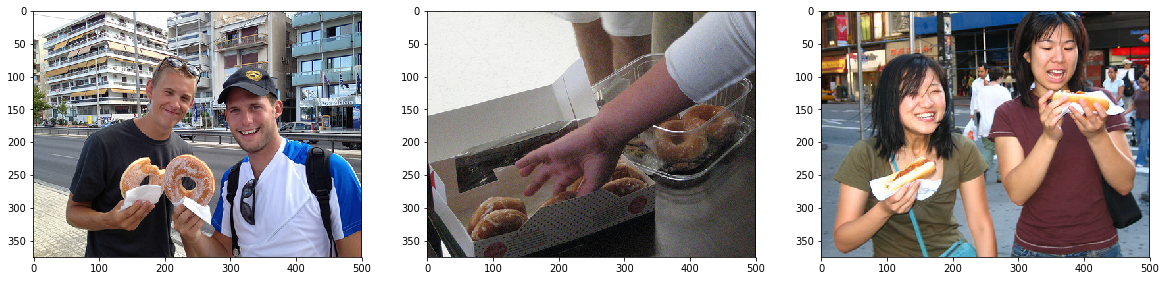

In [38]:
show_triplet(4)

## Filter by Resnet rank

In [53]:
t1_in_rerank = []
t2_in_rerank = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    ranked_set = set(get_reranked_ids('vg_coco', int(row['query_id'])))
    if row['target_id1'] in ranked_set:
        t1_in_rerank.append(True)
    else:
        t1_in_rerank.append(False)
    
    if row['target_id2'] in ranked_set:
        t2_in_rerank.append(True)
    else:
        t2_in_rerank.append(False)    
df['t1_in_rerank'] = t1_in_rerank
df['t2_in_rerank'] = t2_in_rerank
df['in_rerank'] = ((df['t1_in_rerank']) & (df['t2_in_rerank']))

100%|██████████| 9925/9925 [01:39<00:00, 100.10it/s]


In [54]:
(~df['t1_in_rerank']).sum(), (~df['t2_in_rerank']).sum()

(3394, 3570)

In [55]:
df['in_rerank'].sum()

4228

In [56]:
df = df[df['in_rerank']]

In [57]:
len(df)

4228

## filter by sbert score difference

In [58]:
l_sbert_diff = []
for i, row in df.iterrows():
    score1, score2 = get_sbert(row.name)
    l_sbert_diff.append(np.abs(score1 - score2))
df['sbert_diff'] = l_sbert_diff

In [59]:
df = df[df['sbert_diff'] >= 0.1]
# df = df[df['sbert_diff'] >= 0.05]

In [60]:
len(df)

1752

In [61]:
(df['o1'] + df['o2'] + df['both'] + df['neither']).sum()

5305.0

## Save Updated file

In [62]:
df_result_filtered = df_result[df_result['triplet_id'].apply(lambda x: x in df.index)]
# df_result_filtered.to_csv('results_v2.csv', index=False)

In [63]:
df_triplet_filtered = df_triplet.loc[df.index]
# df_triplet_filtered.to_csv('triplets_v2.csv')

# Compute Agreement Score

In [42]:
'''filter users with low answer count (<10)'''
filter_count = 10
# user_count = df_result.groupby('user_id').count()['id']
user_count = df_result_filtered.groupby('user_id').count()['id']
l_filtered_users = (user_count[user_count > filter_count]).index.to_list()
print(l_filtered_users)
print(len(l_filtered_users))

['Dray.Choe', 'IceAmericano', 'JRW', 'Jinyeong', 'Jonggwon', 'Julyeon Seo', 'LSW', 'chico2121', 'cjhan', 'cnuh', 'edwin.kang', 'eos73', 'epsilon.kim', 'erin122', 'eunjin', 'hexa.ai', 'hihello2', 'hyunji', 'jay.mini', 'jihoon.lee', 'jinhyun.b', 'motherfathergentleman', 'robert.p', 'sungbin.lim', 'wookee3', 'woong.ssang', 'yejun', 'yoomin618']
28


In [68]:
'''user agreement'''
user_agree = {'user': [], 'score': []}
# for user in l_users:
for user in l_filtered_users:    
    print(user)
#     df_answer_person = df_result[df_result['user_id'] == user].sort_values('triplet_id')
    df_answer_person = df_result_filtered[df_result_filtered['user_id'] == user].sort_values('triplet_id')
    l_score = []
    for i, row in df_answer_person.iterrows():
        triplet_id = row['triplet_id']
        if row['answer'] not in (0, 1, 2):
            continue
            
        # ------ filter triplets
        if triplet_id not in df.index:
            continue

        answer = answer_cnt.loc[triplet_id]
        o1, o2, o3, p, q = answer['o1'], answer['o2'], answer['o3'], answer['both'], answer['neither']

#         o1, o2 = answer['o1'], answer['o2']
#         o3 = len(l_users) - o1 - o2

        # requires more than two active votes for the triplet
        if o1 + o2 < 2:
            continue

        if row['answer'] in {0, 1}:
            if row['answer'] == 0:
                oi = o1
            else:
                oi = o2
            s = (oi + 0.5 * p  - 1) / (o1 + o2 + p + q - 1)
        elif row['answer'] == 2:
            s = (0.5 * o1 + 0.5 * o2 + p - 1 ) / (o1 + o2 + p + q - 1)
        else:
            s = 0
#             s = (q - 1) / (o1 + o2 + p + 1 - 1)
        

#         s = (o1 + o2 - 1) / (o1 + o2 + o3 - 1) * (oi - 1) / (o1 + o2 - 1)
        

        l_score.append(s)
    score = np.mean(l_score)
    user_agree['user'].append(user)
    user_agree['score'].append(score)
user_agree = pd.DataFrame(user_agree)    
user_agree.head()
print(user_agree.mean(), user_agree.std())

Dray.Choe
IceAmericano
JRW
Jinyeong
Jonggwon
Julyeon Seo
LSW
chico2121
cjhan
cnuh
edwin.kang
eos73
epsilon.kim
erin122
eunjin
hexa.ai
hihello2
hyunji
jay.mini
jihoon.lee
jinhyun.b
motherfathergentleman
robert.p
sungbin.lim
wookee3
woong.ssang
yejun
yoomin618
score    0.711822
dtype: float64 score    0.053658
dtype: float64


## Agreement between algorithm and human

Let  
$o1, o2$ : the number of times the first (resp. second) image was chosen.  
$p$ : the number of times "both" icon were chosen  
$q$ : the nubmer of times "neither" icon of images were chosen


If an algorithm choses the first or the second image, it recieves the following agreement score  
$$
s = \frac{o_i + 0.5 p - 1}{o_1 + o_2 + p + q - 1}
$$
where $o_i$ $i\in\{1,2\}$ is the choice of the algorithm.

In [13]:
def read_result(algo, query_id, l_target_ids):
    result_path = '/data/project/rw/viewer_CBIR/viewer/vg_coco_results/'
    data = pd.read_csv(os.path.join(result_path, algo, f'{query_id}.tsv'), delimiter='\t', header=None)
    data = data.rename(columns={0:'id', 1:'sim'}).set_index('id')
    return data.loc[[int(s) for s in l_target_ids]].to_dict()['sim']

In [64]:
l_algorithms = ['sbert_rerank100', 'vg_han_norel_h300_epoch_24', 'boo_tfidf', 'vg_gcn_epoch_24', 'resnet']
# l_algorithms = ['v1_resnetweight05_epoch_10_rerank', 'gen_v1_resnet07_epoch_99_rerank', 'gen_v1_resnet07_epoch_99']

# algo_scores = {'triplet_id': list(answer_cnt.index)}
algo_scores = {'triplet_id': list(df.index)}
d_resnet_sim = read_similarity_data('resnet', df_triplet)
for algo in tqdm(l_algorithms):
    d_sim_result = read_similarity_data(algo, df_triplet)
    l_score = []
#     for triplet_id, row in answer_cnt.iterrows():
    for triplet_id, row in df.iterrows():        
        o1, o2, o3, p, q = row['o1'], row['o2'], row['o3'], row['both'], row['neither']

        if o1 + o2  < 2:
            l_score.append(np.nan)
            continue
            
        # get algorithm's prediction
        triplet = df_triplet.loc[triplet_id]
        sim1 = d_sim_result[triplet['query_id']][triplet['target_id1']]
        sim2 = d_sim_result[triplet['query_id']][triplet['target_id2']]
        
        # process reranking
        if (np.isnan(sim1)) and (np.isnan(sim2)):
            print('what?')
            sim1 = d_resnet_sim[triplet['query_id']][triplet['target_id1']]
            sim2 = d_resnet_sim[triplet['query_id']][triplet['target_id2']]
        elif (np.isnan(sim1)) and not (np.isnan(sim2)):
            print('what?')
            sim1 = - np.inf
        elif not (np.isnan(sim1)) and (np.isnan(sim2)):
            print('what?')
            sim2 = - np.inf
        
        if sim1 > sim2:
            oi = o1
        else:
            oi = o2
        
        s = (oi + 0.5 * p ) / (o1 + o2 + p + q )
        l_score.append(s)
    algo_scores[algo] = l_score
algo_scores = pd.DataFrame(algo_scores)


100%|██████████| 5/5 [00:31<00:00,  6.29s/it]


In [65]:
algo_scores.mean()

triplet_id                    4957.963470
sbert_rerank100                  0.723100
vg_han_norel_h300_epoch_24       0.628425
boo_tfidf                        0.613610
vg_gcn_epoch_24                  0.630440
resnet                           0.505644
dtype: float64

In [178]:
algo_scores.mean()

triplet_id                    4957.963470
sbert_rerank100                  0.723100
vg_han_norel_h300_epoch_24       0.628425
boo_tfidf_rerank100              0.613610
vg_gcn_epoch_24                  0.630440
dtype: float64

In [41]:
algo_scores.mean()

triplet_id                    4957.963470
sbert_rerank100                  0.723100
vg_han_norel_h300_epoch_24       0.628425
boo_tfidf                        0.613610
vg_gcn_epoch_24                  0.630440
dtype: float64

In [69]:
l_algorithms = ['random']

algo_scores = {'triplet_id': list(df.index)}

for algo in tqdm(l_algorithms):

    l_score = []

    for triplet_id, row in df.iterrows():        
        o1, o2, o3, p, q = row['o1'], row['o2'], row['o3'], row['both'], row['neither']

        if o1 + o2  < 2:
            l_score.append(np.nan)
            continue
            
        # get algorithm's prediction
        triplet = df_triplet.loc[triplet_id]
        sim1 = np.random.rand()
        sim2 = np.random.rand()
#         sim1 = d_sim_result[triplet['query_id']][triplet['target_id1']]
#         sim2 = d_sim_result[triplet['query_id']][triplet['target_id2']]
        
        
        if sim1 > sim2:
            oi = o1
        else:
            oi = o2
        
        s = (oi + 0.5 * p ) / (o1 + o2 + p + q )
        l_score.append(s)
    algo_scores[algo] = l_score
algo_scores = pd.DataFrame(algo_scores)


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


In [70]:
algo_scores.mean()

triplet_id    4957.963470
random           0.480944
dtype: float64

In [49]:
algo_scores.mean()

triplet_id    5027.786346
random           0.484828
dtype: float64

In [99]:
len(algo_scores)

4228

(array([233., 186., 142., 129.,  43., 472., 297., 109., 442., 740.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

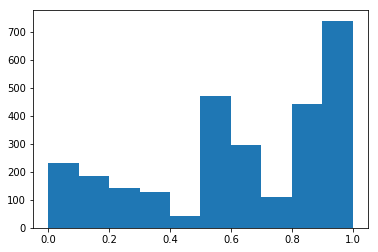

In [103]:
plt.hist(algo_scores['sbert_rerank100'].dropna())

In [27]:
l_sbert_fail = algo_scores[algo_scores['sbert_rerank100']<0.2]['triplet_id'].tolist()

NameError: name 'algo_scores' is not defined

In [149]:
len(l_sbert_fail)

419

In [154]:
print(l_sbert_fail)

[4, 19, 42, 58, 158, 164, 177, 186, 188, 300, 316, 317, 320, 352, 383, 422, 480, 492, 514, 523, 528, 541, 601, 615, 674, 720, 728, 765, 766, 768, 774, 788, 804, 808, 823, 844, 852, 859, 883, 888, 896, 900, 910, 962, 972, 973, 989, 996, 1021, 1023, 1049, 1052, 1066, 1106, 1108, 1172, 1207, 1219, 1221, 1225, 1242, 1265, 1353, 1377, 1385, 1424, 1434, 1475, 1477, 1519, 1534, 1539, 1560, 1588, 1616, 1620, 1633, 1666, 1670, 1699, 1709, 1720, 1725, 1736, 1744, 1746, 1793, 1815, 1822, 1871, 1893, 1900, 1901, 1948, 1979, 1980, 1985, 1987, 2052, 2069, 2070, 2107, 2154, 2156, 2157, 2162, 2177, 2206, 2214, 2225, 2238, 2241, 2272, 2277, 2294, 2299, 2300, 2331, 2350, 2395, 2467, 2474, 2475, 2478, 2626, 2766, 2817, 2831, 2833, 2837, 2844, 2852, 2854, 2858, 2864, 2911, 2927, 2951, 2954, 2962, 2965, 3002, 3005, 3023, 3029, 3147, 3167, 3173, 3226, 3246, 3301, 3360, 3374, 3384, 3391, 3400, 3414, 3422, 3427, 3448, 3453, 3456, 3457, 3459, 3490, 3502, 3508, 3527, 3563, 3607, 3619, 3622, 3638, 3690, 3701, 37

In [150]:
l_failed_q = [df_triplet.loc[tri_id]['query_id'] for tri_id in l_sbert_fail]

In [158]:
l = []
for triid in l_sbert_fail:
    score1, score2 = get_sbert(triid)
    l.append(np.abs(score1 - score2))

In [164]:
l2 = []
for triid in df.index:
    score1, score2 = get_sbert(triid)
    l2.append(np.abs(score1 - score2))

(array([6.38735111, 3.66717551, 1.70459983, 0.91107922, 0.47023444,
        0.33634824, 0.18939998, 0.08163792, 0.04245172, 0.01632758]),
 array([9.53674316e-06, 7.24386357e-02, 1.44867735e-01, 2.17296834e-01,
        2.89725932e-01, 3.62155031e-01, 4.34584130e-01, 5.07013229e-01,
        5.79442328e-01, 6.51871427e-01, 7.24300526e-01]),
 <a list of 10 Patch objects>)

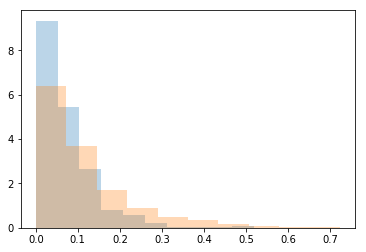

In [166]:
plt.hist(l, density=True, alpha=0.3)
plt.hist(l2, density=True, alpha=0.3)

In [152]:
len(l_failed_q)

419

In [153]:
len(set(l_failed_q))

325

In [155]:
get_sbert(6990)

(0.4930828213691712, 0.4252105951309204)

In [156]:
df.loc[6990]

query_id           2416017
target_id1         2342611
target_id2         2325905
query_obj_cnt           32
target1_obj_cnt         46
target2_obj_cnt         74
o1                       0
o2                       2
both                     1
neither                  0
o3                       1
t1_in_rerank          True
t2_in_rerank          True
in_rerank             True
Name: 6990, dtype: object

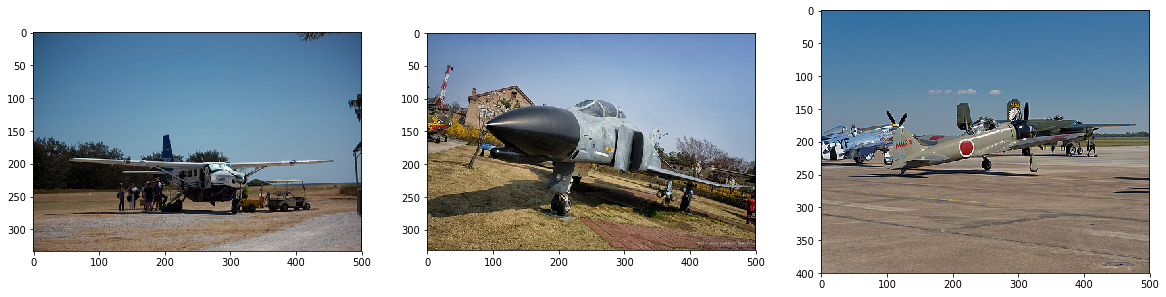

In [157]:
show_triplet(6990)

# Deprecated Codes

* 작업 중 만들었으나 쓰지 않는 코드들

## Get Object Count & Filter by Object Count

In [121]:
gen_scene_graph = '/data/project/rw/CBIR/data/vg_coco/vg_coco_sgg.pkl'   
gen_sg = pickle.load(open(gen_scene_graph, 'rb'))

In [124]:
id2gen_sg = {int(sg_['imgid']): sg_  for sg_ in gen_sg}

In [21]:
'''load scene graph and add triplet features'''
'''GT scene graph'''    
gen_scene_graph = '/data/project/rw/CBIR/vg_generated_sg_adj_full_butd_freq_train.pkl'   
gen_sg = pickle.load(open(gen_scene_graph, 'rb'))
# full scene graph
sg = json.load(open('/data/public/rw/datasets/visual_genome/filtered_scene_graphs_coco.json', 'r'))
id2sg = {int(sg_['image_id']): sg_  for sg_ in sg}

In [22]:
sg[0].keys()

dict_keys(['relationships', 'image_id', 'objects', 'attributes'])

In [23]:
img_ids = [sg_['image_id'] for sg_ in sg]

In [24]:
obj_count = {}
for img_id in img_ids:
    sg_ = id2sg[int(img_id)]
#     obj_count[img_id] = len(sg_['obj_labels'])
    obj_count[img_id] = len(sg_['objects'])

In [25]:
l_exp_ids = list(set(df_triplet['query_id'].tolist() + df_triplet['target_id1'].tolist() + df_triplet['target_id2'].tolist()))

In [26]:
l_expid_obj_cnt = [obj_count[id_] for id_ in l_exp_ids]

Text(0.5,0,'Object Count in GT SG')

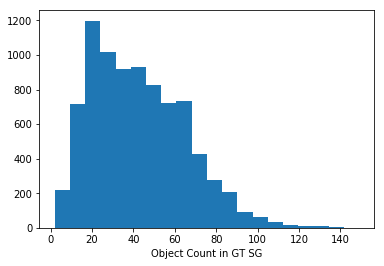

In [27]:
# plt.hist(list(obj_count.values()), bins=20)
plt.hist(l_expid_obj_cnt, bins=20)
plt.xlabel('Object Count in GT SG')

In [28]:
df_triplet['query_obj_cnt'] = df_triplet['query_id'].apply(lambda x: obj_count[x])
df_triplet['target1_obj_cnt'] = df_triplet['target_id1'].apply(lambda x: obj_count[x])
df_triplet['target2_obj_cnt'] = df_triplet['target_id2'].apply(lambda x: obj_count[x])

In [39]:

df = df[df['query_obj_cnt'] >= 10]
df = df[df['target1_obj_cnt'] >= 10]
df = df[df['target2_obj_cnt'] >= 10]

## Filter by Entropy

In [48]:
answer_cnt['p_o1'] = (answer_cnt['o1'] + answer_cnt['both'] * 0.5) / answer_cnt.sum(axis=1)
answer_cnt['p_o2'] = (answer_cnt['o2'] + answer_cnt['both'] * 0.5) / answer_cnt.sum(axis=1)
answer_cnt['p_n'] = (answer_cnt['neither'] ) / answer_cnt.sum(axis=1)

In [49]:
def entropy(x):
    return np.nansum(- x * np.log(x))

In [51]:
answer_cnt['entropy'] = answer_cnt.apply(lambda x: entropy(np.array([x['p_o1'], x['p_o2'], x['p_n']])), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [52]:
answer_cnt

answer,o1,o2,both,neither,p_o1,p_o2,p_n,entropy
triplet_id,,,,,,,,
1,1.0,2.0,0.0,0.0,0.333333,0.600000,0.00000,0.672699
2,0.0,2.0,2.0,0.0,0.250000,0.705882,0.00000,0.592437
3,4.0,0.0,1.0,0.0,0.900000,0.084746,0.00000,0.303985
4,0.0,3.0,0.0,0.0,0.000000,1.000000,0.00000,0.000000
5,5.0,0.0,0.0,0.0,1.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...
9996,1.0,0.0,1.0,1.0,0.500000,0.142857,0.27451,0.979438
9997,3.0,0.0,0.0,0.0,1.000000,0.000000,0.00000,0.000000
9998,2.0,0.0,0.0,0.0,1.000000,0.000000,0.00000,0.000000


In [36]:
df_triplet

,query_id,target_id1,target_id2,query_obj_cnt,target1_obj_cnt,target2_obj_cnt
triplet_id,,,,,,
1,2338816,2338871,2317047,20,11,73
2,2338816,2330684,2339602,20,19,8
3,2338816,2324945,2416236,20,16,34
4,2338816,2340743,2415852,20,48,36
5,2338816,2342962,2411692,20,83,84
...,...,...,...,...,...,...
9996,2322429,2326385,2328658,23,45,17
9997,2322429,2341727,2328658,23,63,17
9998,2322429,2316063,2325873,23,94,16


In [61]:
df_answer = df_triplet.join(answer_cnt).dropna()

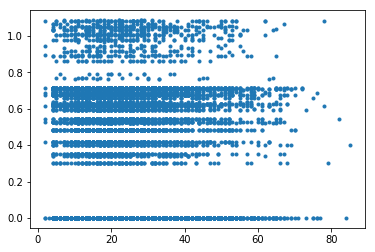

In [65]:
plt.plot(df_answer[['query_obj_cnt', 'target1_obj_cnt', 'target2_obj_cnt']].apply(np.min, axis=1), df_answer['entropy'], '.')

In [11]:
sg[0].keys()

KeyError: 0

In [18]:
df_answer.index

9925